In [1]:
import math
import torch
import gpytorch
import sys
from matplotlib import pyplot as plt
sys.path.append('../')
from LBFGS import FullBatchLBFGS

import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import urllib.request
from scipy.io import loadmat
dataset = 'protein'
if not os.path.isfile(f'../{dataset}.mat'):
    print(f'Downloading \'{dataset}\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1nRb8e7qooozXkNghC5eQS0JeywSXGX2S',
                               f'../{dataset}.mat')

data = torch.Tensor(loadmat(f'../{dataset}.mat')['data'])

df = data[:1500,:]

In [2]:
#df = pd.read_csv('yaz_steak_small.csv')
target = 'LAMB'
df = pd.read_csv('yaz_steak.csv')
df.drop(columns=['DEMAND_DATE', 'STEAK'], inplace=True)
df_target = pd.read_csv('yaz_target.csv')
print(df_target.columns)
df['target'] = df_target[target]
y_max = df.target.max()
df.target = df.target/y_max

Index(['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK'], dtype='object')


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [4]:
data = torch.tensor(df_scaled, dtype=torch.float32)

In [5]:
import numpy as np

N = data.shape[0]
# make train/val/test
n_train = int(0.8 * N)
#n_train = int(1 * N)
train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
test_x, test_y = data[n_train:, :-1], data[n_train:, -1]

# normalize features
mean = train_x.mean(dim=-2, keepdim=True)
std = train_x.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

# normalize labels
mean, std = train_y.mean(),train_y.std()
train_y = (train_y - mean) / std
test_y = (test_y - mean) / std

In [6]:
# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [7]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 1 GPUs.


In [8]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter=100

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.946   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.902   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.858   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.814   lengthscale: 0.855   noise: 0.554
Iter 5/100 - Loss: 0.769   lengthscale: 0.914   noise: 0.513
Iter 6/100 - Loss: 0.722   lengthscale: 0.975   noise: 0.474
Iter 7/100 - Loss: 0.675   lengthscale: 1.040   noise: 0.437
Iter 8/100 - Loss: 0.626   lengthscale: 1.107   noise: 0.402
Iter 9/100 - Loss: 0.577   lengthscale: 1.177   noise: 0.370
Iter 10/100 - Loss: 0.527   lengthscale: 1.249   noise: 0.340
Iter 11/100 - Loss: 0.477   lengthscale: 1.324   noise: 0.311
Iter 12/100 - Loss: 0.427   lengthscale: 1.400   noise: 0.285
Iter 13/100 - Loss: 0.376   lengthscale: 1.479   noise: 0.261
Iter 14/100 - Loss: 0.326   lengthscale: 1.558   noise: 0.238
Iter 15/100 - Loss: 0.276   lengthscale: 1.639   noise: 0.217
Iter 16/100 - Loss: 0.227   lengthscale: 1.720   noise: 0.198
Iter 17/100 - Los

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    # Make predictions on a small number of test points to get the test time caches computed
    #observed_pred = likelihood(model(sample_x))
    observed_pred = likelihood(model(test_x))
    #observed_pred_train = likelihood(model(train_x))

## Old

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x,
          train_y,
          n_devices,
          output_device,
          checkpoint_size,
          preconditioner_size,
          n_training_iter,
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()

    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)

            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))

            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood

import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

model, likelihood = train(train_x, train_y,
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=10000,
                          preconditioner_size=100,
                          n_training_iter=100)

In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    # Make predictions on a small number of test points to get the test time caches computed
    latent_pred = model(test_x[:2, :])
    del latent_pred  # We don't care about these predictions, we really just want the caches.


In [23]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    %time latent_pred = model(test_x)

test_rmse = torch.sqrt(torch.mean(torch.pow(latent_pred.mean - test_y, 2)))
print(f"Test RMSE: {test_rmse.item()}")

CPU times: user 0 ns, sys: 3.05 ms, total: 3.05 ms
Wall time: 2.77 ms
Test RMSE: 0.7905970811843872


In [353]:
#[torch.linspace(0, 0, 200) for i in range(2)].append([torch.linspace(-1,5, 1,5, 200) for i in range(1)])

In [293]:
df_test = pd.DataFrame(np.array(df, dtype=np.float32))

In [294]:
f0 = torch.linspace(-1.95233848, -1.95233848, 200)
f1 = torch.linspace(1.5526242, 1.5526242, 200)
f2 = torch.linspace(-2.5, 2.5, 200)
#f2 = torch.linspace(-1.5000936, -1.5000936, 1)
f3 = torch.linspace(-0.6362436, -0.6362436, 200)
f4 = torch.linspace(-0.1726566, -0.1726566, 200)

In [295]:
df_test[0].unique()

array([0. , 0.5, 1. ], dtype=float32)

In [296]:
np.sort(df_test[2].unique())

array([0.        , 0.16666667, 0.33333334, 0.5       , 0.6666667 ,
       0.8333333 , 1.        ], dtype=float32)

In [297]:
df_test[4].unique()

array([0., 1.], dtype=float32)

In [298]:
df_test[3].unique()

array([0., 1.], dtype=float32)

In [299]:
df_test[1].unique().max()

1.0

In [300]:
df_test = pd.DataFrame(np.array(df, dtype=np.float32))
df_test = df_test[df_test[0]==-1.95233848]
df_test = df_test[df_test[1]==1.5526242]
df_test = df_test[df_test[3]==-0.6362436]
df_test = df_test[df_test[4]==-0.1726566]
#df_test = df_test[df_test[2]==-1.5000936]
df_test

,0,1,2,3,4,5


In [233]:
train_x_fil = torch.tensor(np.array(df_test), dtype=torch.float32).cuda()

In [234]:
sample_x = torch.stack([f0,f1,f2,f3,f4,] , axis=-1).cuda()

In [301]:
sample_x = test_x

NameError: name 'train_x_fil' is not defined

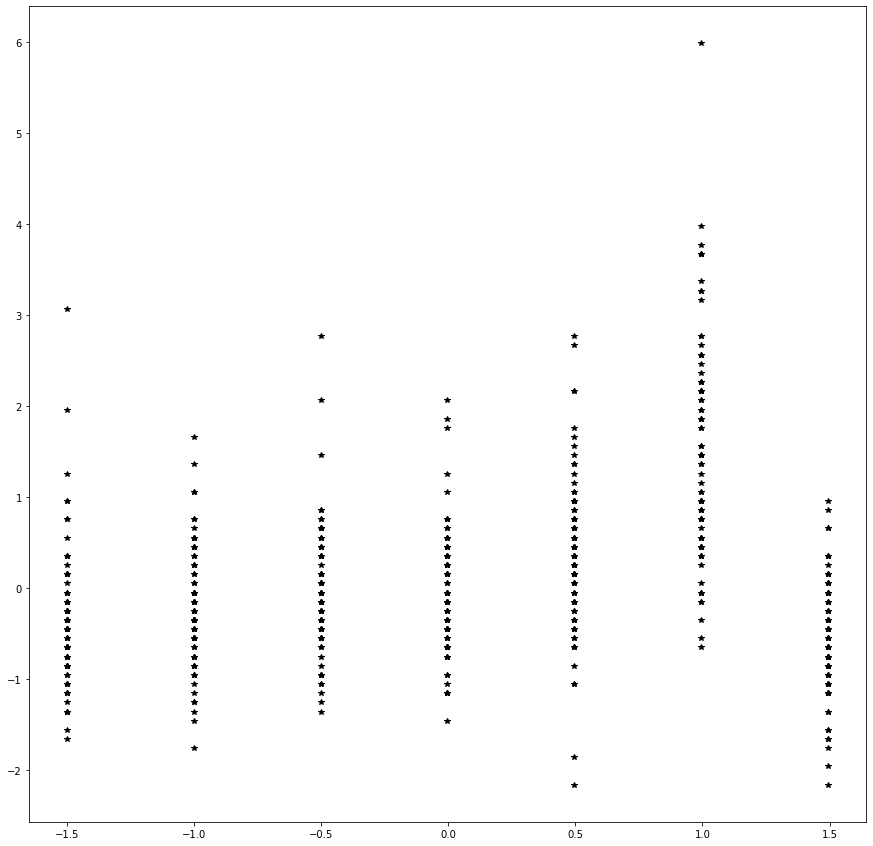

In [14]:
feature_idx=2
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    ax.plot(train_x_fil[:,feature_idx].cpu().numpy(), train_x_fil[:,-1].cpu().numpy(), 'r*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    #ax.plot(train_x[:,1].cpu().numpy(), train_y.cpu().numpy(), 'r*')
    #ax.plot(train_x[:,2].cpu().numpy(), train_y.cpu().numpy(), 'g*')
    #ax.plot(test_x.cpu().numpy(), test_y.cpu().numpy(), 'r*')
    # Plot predictive means as blue line
    #ax.plot(torch.linspace(-2, 1, 200).numpy(), observed_pred.mean.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.cpu().numpy()[:,0], lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## NV

In [12]:
#y_train_unscaled = scaler.inverse_transform(df[n_train:,:])[:,-1]
y_train_unscaled = (scaler.inverse_transform(df_scaled[:n_train,:])[:,-1])*y_max
y_test_unscaled = (scaler.inverse_transform(df_scaled[n_train:,:])[:,-1])*y_max

y_train_unscaled = df.STEAK[:n_train].to_numpy()

y_test_unscaled = df.STEAK[n_train:].to_numpy()

In [13]:
n_features = df_scaled.shape[1]
nv_means = observed_pred.mean.cpu().numpy()
#nv_means = observed_pred_train.mean.cpu().numpy()
nv_means_unscaled = (scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1])*y_max

In [14]:
nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
#nv_sigma = np.sqrt(torch.diag(observed_pred_train.covariance_matrix).cpu().detach().numpy())
nv_sigma_unscaled = (scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1])*y_max

In [15]:
from scipy.stats import norm

In [16]:
def nv_cost(q, y, cu, co):
    if q>y:
        cost = (q-y)*co
    else:
        cost = (y-q)*cu
    return cost

In [18]:
cu = 0.7
co = 1-cu
nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
nv_quantile

36.0

In [19]:
#nv_solution = pred_train+norm.ppf(cu)*nv_sigma_unscaled
nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled

In [20]:
cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
#cost_saa = np.sum([nv_cost(nv_quantile, y, cu, co) for y in y_train_unscaled])
cost_saa

3.935526315789474

In [21]:
#cost_gp =  np.sum([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_train_unscaled)])
cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
cost_gp

3.514834920983566

In [22]:
cost_gp/cost_saa

0.8931041591265496

In [23]:
res = []
for c in range(5,100, 5):
    cu = c/100
    co = 1-cu
    nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
    nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
    cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
    cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
    ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa"})
    res.append(ser_tmp)
    ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp"})
    res.append(ser_tmp)
df_res = pd.DataFrame(res)
df_res.to_csv(f'res_data/gp_res_{target}.csv', index=False)

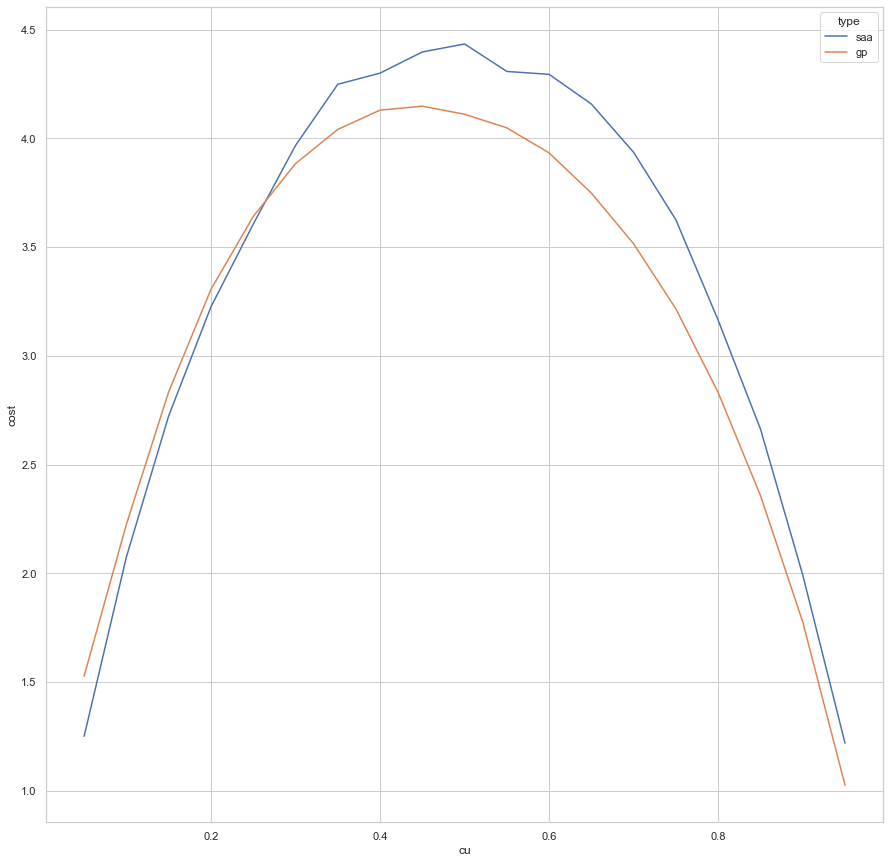

In [24]:
import seaborn as sns
#df_plot = pd.read_csv('all_res.csv')
df_plot = df_res
df_plot = df_plot[~(df_plot.type.isin(["rf_rf", "rf_grf", "rf_oracle"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns_plot = sns.lineplot(data=df_plot, x="cu", y="cost", hue="type");
fig = sns_plot.get_figure()
fig.savefig("output_{target}.png")